In [365]:
import pandas as pd
import numpy as np
import sklearn
import math
import matplotlib.pyplot as plt

In [366]:
df = pd.read_csv('model_data.csv')

In [367]:
df.head()

,Unnamed: 0,Year,Player,Pos,Age,Tm,G,MP,PER,TS%,...,DBPM,3P%,2P%,FT%,TmNetRtg,Next Rtg,Next WS,Veteran Value,VV Class,Starters
0,1,1997,Vinny Del,SG,30.0,SAS,72.0,2243.0,14.4,0.529,...,-2.3,0.314,0.501,0.868,-8.8,4.4,3.7,2903.225806,0,1
1,3,1997,Avery Johnson,PG,31.0,SAS,76.0,2472.0,15.0,0.517,...,-3.0,0.231,0.487,0.690,-8.8,4.4,6.7,14558.823529,0,1
2,7,1997,Charles Barkley,PF,33.0,HOU,53.0,2009.0,23.0,0.581,...,2.8,0.283,0.569,0.694,4.7,-0.9,8.6,-1276.595745,1,1
3,8,1997,Clyde Drexler,SG,34.0,HOU,62.0,2271.0,19.9,0.548,...,1.7,0.355,0.493,0.750,4.7,-0.9,6.8,-2407.407407,1,1
4,9,1997,Mario Elie,SF,33.0,HOU,78.0,2687.0,14.3,0.662,...,0.1,0.420,0.572,0.896,4.7,-0.9,3.8,-8595.505618,1,1


## Pre-Processing

In [368]:
df.columns

Index(['Unnamed: 0', 'Year', 'Player', 'Pos', 'Age', 'Tm', 'G', 'MP', 'PER',
       'TS%', '3PAr', 'FTr', 'ORB%', 'DRB%', 'AST%', 'STL%', 'BLK%', 'TOV%',
       'USG%', 'OWS', 'DWS', 'WS', 'WS/48', 'OBPM', 'DBPM', '3P%', '2P%',
       'FT%', 'TmNetRtg', 'Next Rtg', 'Next WS', 'Veteran Value', 'VV Class',
       'Starters'],
      dtype='object')

<AxesSubplot:ylabel='Frequency'>

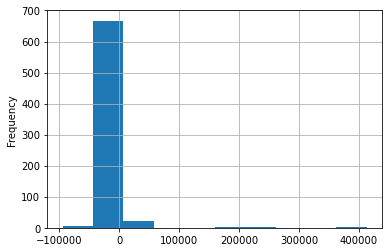

In [369]:
df['Veteran Value'].plot.hist(grid=True)

In [370]:
# calculate summary statistics
data = df['Veteran Value']
data_mean, data_std = np.mean(data), np.std(data)
# identify outliers
cut_off = data_std * 3
lower, upper = data_mean - cut_off, data_mean + cut_off
print(lower, upper)
lower, upper = -10000, 10000

-63806.593259548616 63843.64009831145


In [371]:
outliers = [x[0] for x in enumerate(data) if x[1] < lower or x[1] > upper]


In [372]:
df.drop(index=outliers,inplace=True)

In [373]:
outliers = [x[0] for x in enumerate(df['Veteran Value']) if x[1] < lower or x[1] > upper]
outliers

[]

<AxesSubplot:ylabel='Frequency'>

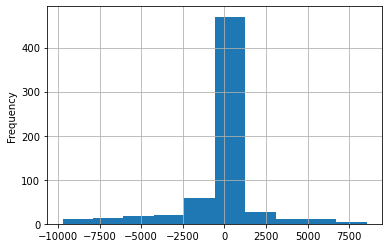

In [374]:
df['Veteran Value'].plot.hist(grid=True)

In [375]:
target = df['Veteran Value']

def getClass(vv):
    d25, d50, d75 = df['Veteran Value'].describe()['25%'], df['Veteran Value'].describe()['50%'], df['Veteran Value'].describe()['75%']
    if vv < -5000:
        return 0
    elif -5000 <= vv < -1000:
        return 1
    elif -1000 <= vv < 0:
        return 2
    elif 0 <= vv < 1000:
        return 3
    elif 1000 <= vv < 3000:
        return 4
    elif 3000 <= vv:
        return 5
    
df['VV Class'] = [getClass(vv) for vv in df['Veteran Value']]
target_class = df['VV Class']

In [376]:
df['Veteran Value'].describe()

count     641.000000
mean     -255.310744
std      2189.684947
min     -9730.639731
25%         0.161765
50%         4.359133
75%        68.129032
max      8566.433566
Name: Veteran Value, dtype: float64

In [377]:
df.drop(['Unnamed: 0','Age','Year','Player','Pos','Tm','Next WS','WS','Next Rtg','TmNetRtg','Veteran Value', 'VV Class'], axis=1, inplace=True)

In [378]:
df.columns

Index(['G', 'MP', 'PER', 'TS%', '3PAr', 'FTr', 'ORB%', 'DRB%', 'AST%', 'STL%',
       'BLK%', 'TOV%', 'USG%', 'OWS', 'DWS', 'WS/48', 'OBPM', 'DBPM', '3P%',
       '2P%', 'FT%', 'Starters'],
      dtype='object')

In [379]:
#try scaling values

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df)


In [380]:
from sklearn.model_selection import train_test_split
xtrain, xtest, ytrain, ytest = train_test_split(scaled_data, target_class.values, random_state=42)

### Logistic Regression Classifier

In [381]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
clf = LogisticRegression(tol=1e-4, max_iter=1000, random_state=0).fit(xtrain, ytrain)
clf.predict(xtest)
clf.predict_proba(xtest)
clf.score(xtest,ytest)

0.6832298136645962

In [382]:
metrics.roc_auc_score(ytest,clf.predict_proba(xtest),multi_class='ovr')

0.6477007624870357

### KNN Classifier

In [383]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics

n_neighbors=15
neigh = KNeighborsClassifier(n_neighbors)
neigh.fit(xtrain, ytrain)

KNeighborsClassifier(n_neighbors=15)

In [384]:
neigh.predict_proba(xtest)
neigh.score(xctest,yctest)

0.2342857142857143

In [385]:
metrics.roc_auc_score(ytest,neigh.predict_proba(xtest),multi_class='ovr')

0.5831359587536598

### Random Forests Classifier

In [386]:
from sklearn.ensemble import RandomForestClassifier


rf = RandomForestClassifier(n_estimators=250, max_depth=50, min_samples_leaf=10, min_samples_split = 10, max_features=10)
rf.fit(xtrain, ytrain)
rf.predict_proba(xtest)
rf.score(xtest,ytest)

0.6832298136645962

In [387]:
metrics.roc_auc_score(ytest,rf.predict_proba(xtest),multi_class='ovr')

0.5708658292995925

### Boosted Classifier


In [388]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

abc = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(min_samples_split=2**6, max_depth=10), 
                         n_estimators=225, learning_rate=0.5)
abc.fit(xtrain, ytrain)
abc.predict_proba(xtest)
abc.score(xtest,ytest)

0.6894409937888198

In [389]:
metrics.roc_auc_score(ytest,abc.predict_proba(xtest),multi_class='ovr')

0.6211652474645523

### Neural Network

In [390]:
from sklearn.neural_network import MLPClassifier

mlpc = MLPClassifier(hidden_layer_sizes=(1000,100,10),activation='relu',learning_rate_init=0.001,batch_size=256, verbose=True,max_iter=100)
mlpc.fit(xtrain, ytrain)
mlpc.predict_proba(xtest)
mlpc.score(xtest,ytest)


Iteration 1, loss = 1.97844663
Iteration 2, loss = 1.69998579
Iteration 3, loss = 1.48990651
Iteration 4, loss = 1.30260975
Iteration 5, loss = 1.20831273
Iteration 6, loss = 1.22209619
Iteration 7, loss = 1.26511413
Iteration 8, loss = 1.26496531
Iteration 9, loss = 1.22570686
Iteration 10, loss = 1.19253641
Iteration 11, loss = 1.17470989
Iteration 12, loss = 1.17361886
Iteration 13, loss = 1.17540912
Iteration 14, loss = 1.16899415
Iteration 15, loss = 1.15781411
Iteration 16, loss = 1.14840221
Iteration 17, loss = 1.14346877
Iteration 18, loss = 1.14496726
Iteration 19, loss = 1.14433392
Iteration 20, loss = 1.14122480
Iteration 21, loss = 1.13554836
Iteration 22, loss = 1.13207471
Iteration 23, loss = 1.13166579
Iteration 24, loss = 1.13027092
Iteration 25, loss = 1.12722609
Iteration 26, loss = 1.12381481
Iteration 27, loss = 1.12137932
Iteration 28, loss = 1.12012090
Iteration 29, loss = 1.11826549
Iteration 30, loss = 1.11613748
Iteration 31, loss = 1.11455763
Iteration 32, los

/opt/anaconda3/envs/py38/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


0.6832298136645962

In [391]:
metrics.roc_auc_score(ytest,mlpc.predict_proba(xtest),multi_class='ovr')

0.6285038766896752

### Voting Classifier

In [392]:
from sklearn.ensemble import VotingClassifier 
from sklearn.ensemble import StackingClassifier

estimator = [] 
estimator.append(('RFC',rf))
estimator.append(('LRC',clf))
estimator.append(('ABC',abc))
estimator.append(('MLP',mlpc))


vot_soft = VotingClassifier(estimators = estimator, voting='soft', verbose=True) 
vot_soft.fit(xtrain, ytrain)
vot_soft.predict_proba(xtest)
vot_soft.score(xtest,ytest)

[Voting] ...................... (1 of 4) Processing RFC, total=   0.9s
[Voting] ...................... (2 of 4) Processing LRC, total=   0.0s
[Voting] ...................... (3 of 4) Processing ABC, total=   1.3s
Iteration 1, loss = 2.05586126
Iteration 2, loss = 1.81809291
Iteration 3, loss = 1.64218328
Iteration 4, loss = 1.43656200
Iteration 5, loss = 1.28042558
Iteration 6, loss = 1.26832691
Iteration 7, loss = 1.30948401
Iteration 8, loss = 1.30132534
Iteration 9, loss = 1.25633385
Iteration 10, loss = 1.22781226
Iteration 11, loss = 1.22793307
Iteration 12, loss = 1.22672505
Iteration 13, loss = 1.22227713
Iteration 14, loss = 1.21337990
Iteration 15, loss = 1.20458072
Iteration 16, loss = 1.20030642
Iteration 17, loss = 1.19767415
Iteration 18, loss = 1.19611518
Iteration 19, loss = 1.19264351
Iteration 20, loss = 1.18777023
Iteration 21, loss = 1.18265650
Iteration 22, loss = 1.17898209
Iteration 23, loss = 1.17618264
Iteration 24, loss = 1.17307489
Iteration 25, loss = 1.16966

/opt/anaconda3/envs/py38/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


0.6832298136645962

In [393]:
metrics.roc_auc_score(ytest,vot_soft.predict_proba(xtest),multi_class='ovr')

0.6542899041315925